In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime

In [2]:
# MODIFIABLE

Date_fin_train = '2021-10-31'    # <= Inférieur ou Egal
Nombre_jours_test = 180

In [3]:
# NON MODIFIABLE

Date_debut_test = pd.to_datetime(Date_fin_train)

Date_fin_test =  str(Date_debut_test + timedelta(Nombre_jours_test))
Date_debut_test = Date_fin_train
Date_fin_test

'2022-04-29 00:00:00'

In [4]:
df = pd.read_csv('../raw_data/data_preparation.csv', index_col=[0])
df

,Date,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,TCO Thermique (%),TCH Thermique (%),TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),Column 30,YEAR,MONTH,DAY,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WS50M,...,bank_holiday,school_holidays,season,num_day,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12,t - 13,t - 14,t - 15,t - 16,t - 17,t - 18,t - 19,t - 20,t - 21,t - 22,t - 23,t - 24,t - 25,t - 26,t - 27,t - 28,t - 29,t - 30
32,2013-02-02,4464,262321.0,15464.0,0.0,1574.0,2710.0,57188.0,0.0,3215.0,182068.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,2,5.55,2.13,3.84,5.69,7.38,8.87,1.48,4.82,79.19,1.94,95.99,12.23,15.88,...,0.0,0,1,33,0.537677,0.843151,0.906686,0.421806,0.764891,-0.644159,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0,286799.0,285526.0
33,2013-02-03,4464,273743.0,15644.0,0.0,1273.0,3718.0,58723.0,0.0,3211.0,191068.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,3,2.96,-2.28,0.33,3.13,9.71,8.87,-0.84,3.30,69.88,0.02,97.48,9.45,12.35,...,0.0,0,1,34,0.552101,0.833777,0.920659,0.390368,0.718792,-0.695225,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0,286799.0
34,2013-02-04,4464,295369.0,28333.0,0.0,570.0,3381.0,78809.0,0.0,3134.0,181039.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,4,4.67,1.85,3.26,4.77,11.67,10.80,-0.88,4.52,82.94,0.00,98.21,7.31,10.12,...,0.0,0,1,35,0.566362,0.824157,0.933542,0.358468,0.669290,-0.743001,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0,267848.0
35,2013-02-05,4464,287424.0,38139.0,0.0,764.0,2067.0,72157.0,0.0,3162.0,171033.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,5,6.65,5.23,5.94,6.64,8.27,11.44,3.16,5.68,89.69,0.19,97.68,6.63,9.32,...,0.0,0,1,36,0.580455,0.814292,0.945320,0.326144,0.616621,-0.787260,295369.0,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0,257432.0
36,2013-02-06,4464,294084.0,50421.0,0.0,816.0,2624.0,70043.0,0.0,3227.0,166848.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2013,2,6,2.71,0.23,1.47,2.94,7.97,6.41,-1.56,4.03,84.50,0.10,96.65,6.42,8.96,...,0.0,0,1,37,0.594376,0.804187,0.955979,0.293434,0.561034,-0.827793,287424.0,295369.0,273743.0,262321.0,266134.0,268874.0,285681.0,303496.0,303546.0,298866.0,309993.0,321288.0,313799.0,314414.0,306209.0,309629.0,290859.0,325285.0,347705.0,346695.0,332304.0,326236.0,305170.0,280488.0,278107.0,280801.0,284001.0,283434.0,280984.0,270102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,2022-05-11,4464,218296.0,34225.0,0.0,1909.0,10139.0,40944.0,-306.0,3115.0,128276.0,0.0,0.0,0.0,0.0

#  Pipeline

In [5]:
preproc_MinMaxScaler = make_pipeline(MinMaxScaler())
preproc_StandardScaler = make_pipeline(StandardScaler()) 
preproc_RobustScaler = make_pipeline( RobustScaler())

In [6]:
min_max = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7', 't - 8', 't - 9',
       't - 10', 't - 11', 't - 12', 't - 13', 't - 14', 't - 15', 't - 16',
       't - 17', 't - 18', 't - 19', 't - 20', 't - 21', 't - 22', 't - 23',
       't - 24', 't - 25', 't - 26', 't - 27', 't - 28', 't - 29', 't - 30']
stand = ['T2MDEW','T2M_RANGE']
robus = ['T2M', 'T2MWET', 'TS', 'T2M_MAX', 'T2M_MIN','QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 
         'WS10M', 'WS50M']

In [7]:
preproc = make_column_transformer(
    (preproc_MinMaxScaler, min_max),
    (preproc_StandardScaler, stand),
    (preproc_RobustScaler, robus),
    remainder="passthrough")

preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
                                  't - 6', 't - 7', 't - 8', 't - 9', 't - 10',
                                  't - 11', 't - 12', 't - 13', 't - 14',
                                  't - 15', 't - 16', 't - 17', 't - 18',
                                  't - 19', 't - 20', 't - 21', 't - 22',
                                  't - 23', 't - 24', 't - 25', 't - 26',
                                  't - 27', 't - 28', 't - 29', 't - 30']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['T2MDEW', 'T2M_RANGE']),

In [8]:
model_xgb = XGBRegressor(colsample_bytree = 1, 
                         gamma= 0.1, 
                         max_depth= 16, 
                         min_child_weight= 6, 
                         n_estimators= 100,
                         learning_rate=0.1)

In [9]:
pipeline_xgb_final = make_pipeline(preproc,model_xgb)
pipeline_xgb_final

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7', 't - 8', 't - 9',
                                                   't - 10', 't - 11', 't - 12',
                                                   't - 13', 't - 14', 't - 15',
                                                   't - 16', 't - 17', 't - 18',
                                                   't - 19', 't - 20', 't - 21',
                                                   't - 22', 't - 23', 't - 24',
                              

# Création data frame

In [10]:
df_train = df[ (df["Date"] <= Date_fin_train)]
df_test = df[ (df["Date"] > Date_debut_test) & (df["Date"] <= Date_fin_test)]

In [11]:
X_train = df_train.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 'MONTH', 'DAY', 'season', 'num_day'])

y_train = df_train['Consommation (MW)']

In [12]:
X_test = df_test.drop(columns=['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30','YEAR', 
        'MONTH', 'DAY', 'season', 'num_day',
       ])

y_test = df_test['Consommation (MW)']

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3194, 56)
(3194,)
(180, 56)
(180,)


In [14]:
X_test[['t - 26', 't - 27', 't - 28', 't - 29', 't - 30']]

,t - 26,t - 27,t - 28,t - 29,t - 30
3226,190750.0,186279.0,182922.0,175646.0,180184.0
3227,191295.0,190750.0,186279.0,182922.0,175646.0
3228,194530.0,191295.0,190750.0,186279.0,182922.0
3229,184697.0,194530.0,191295.0,190750.0,186279.0
3230,179549.0,184697.0,194530.0,191295.0,190750.0
...,...,...,...,...,...
3401,220132.0,210060.0,208339.0,201626.0,213192.0
3402,215684.0,220132.0,210060.0,208339.0,201626.0
3403,236014.0,215684.0,220132.0,210060.0,208339.0
3404,251164.0,236014.0,215684.0,220132.0,210060.0


In [15]:
X_test.columns

Index(['T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
       'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS50M', 'sin_month',
       'cos_month', 'week_day', 'sin_day', 'cos_day', 'bank_holiday',
       'school_holidays', 'sin365_1', 'cos365_1', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12',
       't - 13', 't - 14', 't - 15', 't - 16', 't - 17', 't - 18', 't - 19',
       't - 20', 't - 21', 't - 22', 't - 23', 't - 24', 't - 25', 't - 26',
       't - 27', 't - 28', 't - 29', 't - 30'],
      dtype='object')

# Fit model

In [16]:
pipeline_xgb_final.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['t - 1', 't - 2', 't - 3',
                                                   't - 4', 't - 5', 't - 6',
                                                   't - 7', 't - 8', 't - 9',
                                                   't - 10', 't - 11', 't - 12',
                                                   't - 13', 't - 14', 't - 15',
                                                   't - 16', 't - 17', 't - 18',
                                                   't - 19', 't - 20', 't - 21',
                                                   't - 22', 't - 23', 't - 24',
                              

In [17]:
X_test.shape

(180, 56)

# Prédictions

In [18]:
predictions = []
X_test_i = pd.DataFrame([X_test.iloc[0,26:]])

X_test_0 = pd.DataFrame([X_test.iloc[0,:]])

y_i= pipeline_xgb_final.predict(X_test_0)

predictions.append(y_i[0])

In [19]:
for i in range (1,Nombre_jours_test):
    X_test_features = pd.DataFrame([X_test.iloc[i,:26]])

    
    X_test_i.iloc[0,1:] = X_test_i.iloc[0,:-1]
    X_test_i.iloc[0,0] = y_i[0]
    
    X_test_decal = pd.DataFrame(X_test_i)
    
 
    X_test_pred = pd.merge(left = X_test_features.reset_index(drop = True), right = X_test_decal.reset_index(drop = True),
                left_index = True, right_index = True)
    
    y_i= pipeline_xgb_final.predict(X_test_pred)
    

    predictions.append(y_i[0])

In [20]:
len(predictions)

180

In [21]:
X_train.shape

(3194, 56)

# Lecture prédictions

In [22]:
type(y_test)

pandas.core.series.Series

In [23]:
y_test_list = y_test.tolist()

In [24]:
y_test_list

[188935.0,
 203512.0,
 214537.0,
 229969.0,
 238739.0,
 229840.0,
 230063.0,
 232697.0,
 236347.0,
 231720.0,
 212996.0,
 219275.0,
 207757.0,
 211178.0,
 233637.0,
 229399.0,
 238390.0,
 241304.0,
 240611.0,
 230012.0,
 231952.0,
 243757.0,
 243452.0,
 246629.0,
 254417.0,
 259680.0,
 262056.0,
 269774.0,
 291928.0,
 305772.0,
 301568.0,
 292188.0,
 305131.0,
 288467.0,
 282151.0,
 300417.0,
 299330.0,
 292962.0,
 303355.0,
 312649.0,
 296111.0,
 291382.0,
 304035.0,
 301230.0,
 291292.0,
 297442.0,
 296310.0,
 279167.0,
 278483.0,
 302995.0,
 307396.0,
 301828.0,
 297127.0,
 273445.0,
 241801.0,
 243273.0,
 269418.0,
 264694.0,
 244240.0,
 233162.0,
 242401.0,
 238154.0,
 244688.0,
 264457.0,
 270029.0,
 272530.0,
 295703.0,
 307289.0,
 286384.0,
 270763.0,
 286741.0,
 303781.0,
 311252.0,
 313535.0,
 311759.0,
 298145.0,
 293809.0,
 304453.0,
 304895.0,
 301276.0,
 303272.0,
 308500.0,
 299123.0,
 288987.0,
 301829.0,
 298049.0,
 302238.0,
 300368.0,
 296988.0,
 277779.0,
 265256.0,

In [25]:
MAPE = mean_absolute_percentage_error(y_test, predictions)
MAPE

0.02717062537406969

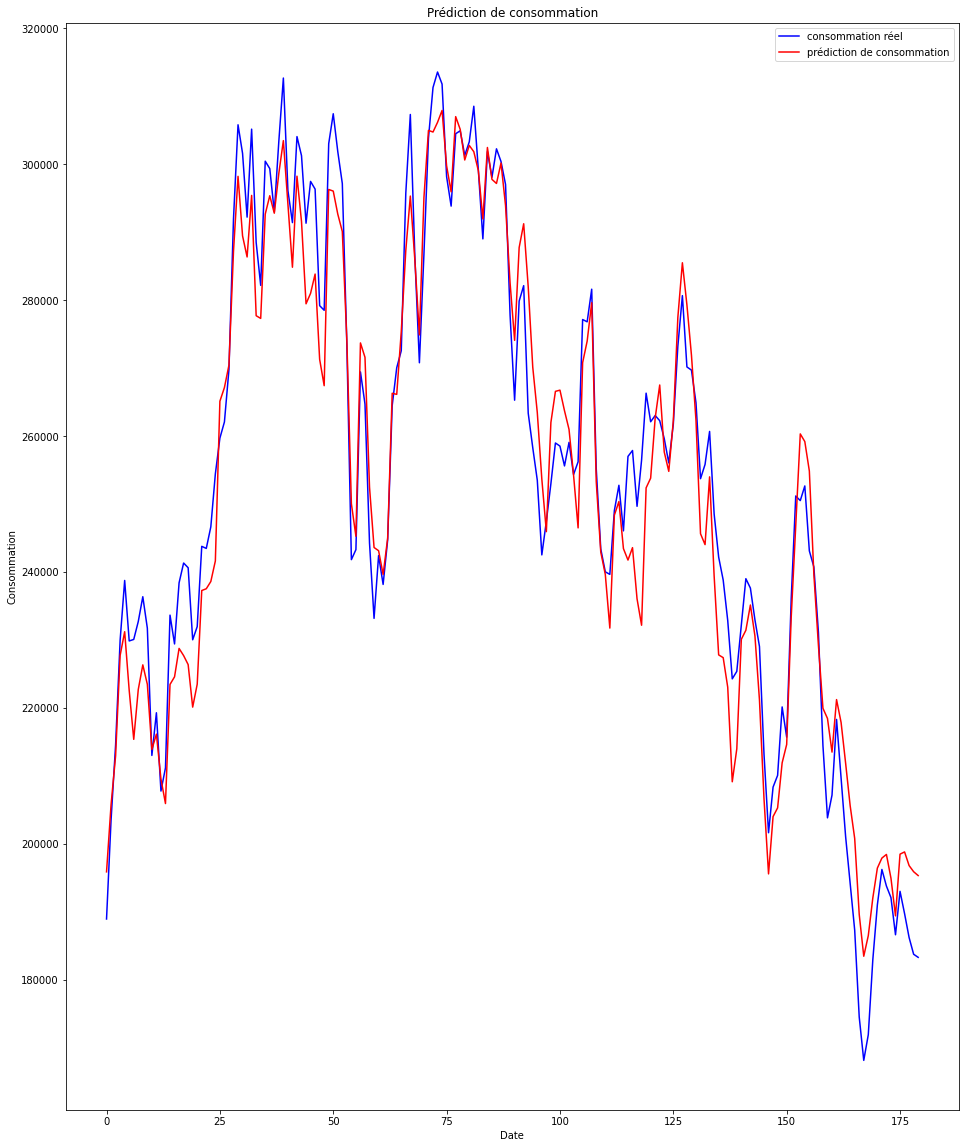

In [26]:
plt.figure(figsize=(16,20))#figsize=(10,6)
plt.plot(y_test_list, color='blue', label='consommation réel')
plt.plot(predictions, color='red', label='prédiction de consommation')
plt.title('Prédiction de consommation')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show()

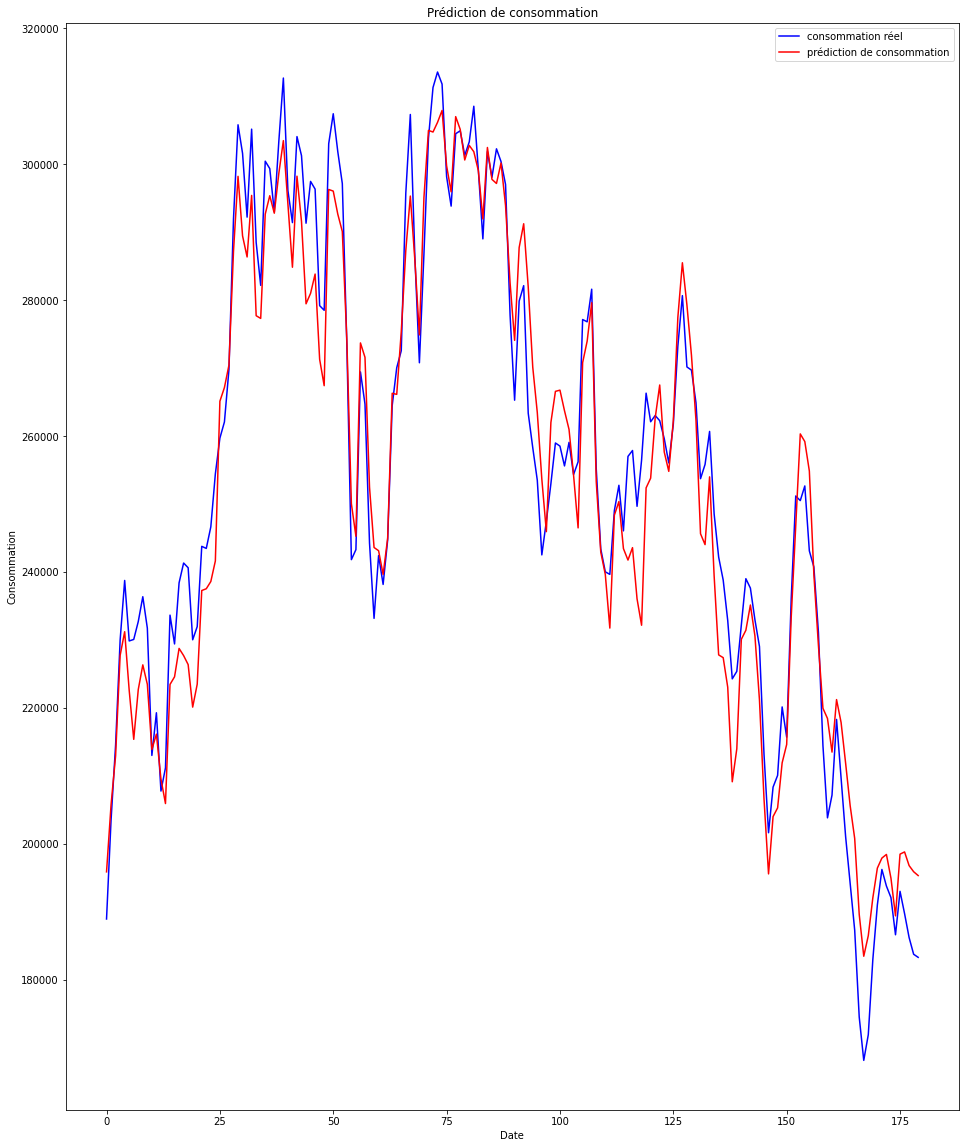

In [27]:
plt.figure(figsize=(16,20))#figsize=(10,6)
plt.plot(y_test_list, color='blue', label='consommation réel')
plt.plot(predictions, color='red', label='prédiction de consommation')
plt.title('Prédiction de consommation')
plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show()

In [28]:
print(f'Durée entrainement = {X_train.shape[0]} // Date fin de train = {Date_debut_test}  // Nombre jours de prédictions = {Nombre_jours_test} // MAPE = {MAPE}')

Durée entrainement = 3194 // Date fin de train = 2021-10-31  // Nombre jours de prédictions = 180 // MAPE = 0.02717062537406969


In [29]:
# Durée entrainement = 3255 // Date fin de train = 2021-12-31  // Nombre jours de prédictions = 14 // MAPE = 0.020387443598371847
# Durée entrainement = 2159 // Date fin de train = 2018-12-31  // Nombre jours de prédictions = 720 // MAPE = 0.04392174749255917
# Durée entrainement = 3133 // Date fin de train = 2021-08-31  // Nombre jours de prédictions = 14 // MAPE = 0.019562152727553097
# Durée entrainement = 3194 // Date fin de train = 2021-10-31  // Nombre jours de prédictions = 14 // MAPE = 0.02608112365233331
# Durée entrainement = 3345 // Date fin de train = 2022-03-31  // Nombre jours de prédictions = 14 // MAPE = 0.04344918094182426
# Durée entrainement = 3194 // Date fin de train = 2021-10-31  // Nombre jours de prédictions = 180 // MAPE = 0.02717062537406969